In [51]:
import sys
sys.path.append('../../HelperFiles')

from helper_shapley_sampling import *
from helper_indep import *
from helper import *
sys.path.append('../Code')
from helper_sim import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os.path import join
from sklearn.linear_model import LogisticRegression


In [52]:
X_train, y_train, X_test, y_test, mapping_dict = loaddata("credit") # credit
xloc = X_test[0:1]

## Shapley Sampling
### Independent Features

In [57]:
def diffs_to_avg_pred(mod, n=10):
        np.random.seed(0)
        model, gradfn, hessfn, sds = fitmodgradhess(mod,X_train,y_train,X_test,y_test)

        gradient = gradfn(model, xloc, sds)
        hessian = hessfn(model, xloc, sds)
        avg_pred = (model(xloc)-np.mean(model(X_train))).item()
        print(round(avg_pred, 2))

        independent_features = True
        cv_sum, vanilla_sum = [], []
        for i in range(n):
                obj_ss = cv_shapley_sampling(model, X_train, xloc, 
                                        independent_features,
                                        gradient, hessian,
                                        mapping_dict=mapping_dict,
                                        M=100, n_samples_per_perm=10)
                final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_ss
                cv_sum.append(np.sum(final_ests))
                vanilla_sum.append(np.sum(vshap_ests_model))
                if i==0: print("Avg expected var reduct: {}".format(round(np.nanmean(corr_ests**2), 2)))
                if (i+1)%5==0: print(i+1)
        cv_diffs = [abs(s - avg_pred) for s in cv_sum]
        vanilla_diffs = [abs(s - avg_pred) for s in vanilla_sum]
        return cv_diffs, vanilla_diffs
n = 20
cv_diffs1, vanilla_diffs1 = diffs_to_avg_pred("glm", n)
cv_diffs2, vanilla_diffs2 = diffs_to_avg_pred("rf", n)
cv_diffs3, vanilla_diffs3 = diffs_to_avg_pred("nn", n)

Class imbalance: 72.0
Estimation accuracy: 74.0
0.23
Avg expected var reduct: 0.94
5
10
15
20
Class imbalance: 72.0
Estimation accuracy: 74.5
0.2
Avg expected var reduct: 0.17
5
10
15
20
Epoch 1/5, Loss: 0.6694
Epoch 2/5, Loss: 0.6321
Epoch 3/5, Loss: 0.6121
Epoch 4/5, Loss: 0.6129
Epoch 5/5, Loss: 0.5723
113/200 predictions are for positive class; really 144
Balanced sampling. 70% accuracy
0.1
Avg expected var reduct: 0.65
5
10
15
20


In [58]:
cv_diffs1b = list(cv_diffs1 /np.mean(vanilla_diffs1))
cv_diffs2b = list(cv_diffs2 /np.mean(vanilla_diffs2))
cv_diffs3b = list(cv_diffs3 /np.mean(vanilla_diffs3))
vanilla_diffs1b = list(vanilla_diffs1 /np.mean(vanilla_diffs1))
vanilla_diffs2b = list(vanilla_diffs2 /np.mean(vanilla_diffs2))
vanilla_diffs3b = list(vanilla_diffs3 /np.mean(vanilla_diffs3))


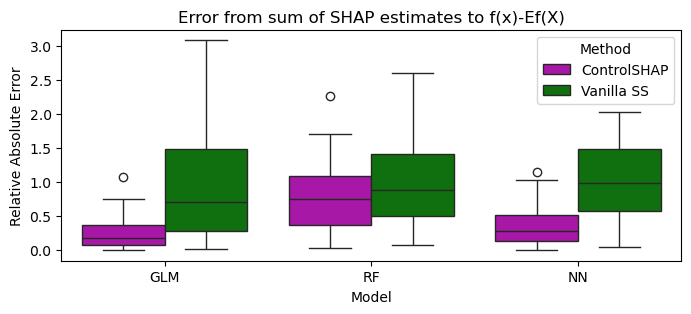

In [59]:
n = len(cv_diffs1)
method = (["ControlSHAP"]*n + ["Vanilla SS"]*n)*3
models = ["GLM"]*2*n + ["RF"]*2*n + ["NN"]*2*n
diffs_from_avg = cv_diffs1b + vanilla_diffs1b + cv_diffs2b + vanilla_diffs2b + cv_diffs3b + vanilla_diffs3b
df = pd.DataFrame()
df["Method"] = method
df["Model"] = models
df["Error"] = diffs_from_avg

import seaborn as sns
plt.figure(figsize=(8,3))
ax = sns.boxplot(data=df, x='Model', y='Error', hue='Method', palette=["m", "g"])
plt.savefig("../PaperFigs/error_from_avg.png", bbox_inches='tight')
plt.title("Error from sum of SHAP estimates to f(x)-Ef(X)")
plt.ylabel("Relative Absolute Error")
plt.show()


### Dependent Features
Guarantee of adding to $f(x)-Ef(X)$ doesn't hold here!

In [60]:
# model, gradfn, hessfn, sds = fitmodgradhess("glm",X_train,y_train,X_test,y_test)
# feature_means = np.mean(X_train, axis=0)
# cov_mat = np.cov(X_train, rowvar=False)
# cov_mat = correct_cov(cov_mat,Kr=10000)
# gradient = gradfn(model, xloc, sds)
# hessian = hessfn(model, xloc, sds)
# avg_pred = (model(xloc)-np.mean(model(X_train))).item()
# print(round(avg_pred, 2))

# M_linear = 1000
# D_matrices = make_all_lundberg_matrices(M_linear, cov_mat)

# import warnings
# warnings.filterwarnings('ignore')
# cv_sum1, vanilla_sum1 = [], []
# independent_features = False
# for i in range(20):
#     obj_ss = cv_shapley_sampling(model, X_train, xloc, 
#                             independent_features,
#                             gradient, 
#                             mapping_dict=mapping_dict,
#                             D_matrices=D_matrices,
#                             cov_mat=cov_mat,
#                             M=100, n_samples_per_perm=10)
#     final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_ss
#     cv_sum1.append(np.sum(final_ests))
#     vanilla_sum1.append(np.sum(vshap_ests_model))
#     if (i+1)%2==0: print(i+1)

# cv_avg_diff = np.mean([abs(s - avg_pred) for s in cv_sum1])
# vanilla_avg_diff = np.mean([abs(s - avg_pred) for s in vanilla_sum1])
# print(cv_avg_diff, vanilla_avg_diff)

## KernelSHAP
There will be some bias added here, since by definition the vanilla sum is always exactly $f(x)-Ef(X)$.

In [61]:
# np.random.seed(1)
# cv_sum2, vanilla_sum2 = [], []
# independent_features = True
# shap_CV_true_indep = compute_true_shap_cv_indep(xloc, gradient, hessian, feature_means, cov_mat, mapping_dict=mapping_dict)

# for i in range(20):
#     obj = cv_kshap_compare(fmodel, X_train, xloc,
#                     independent_features,
#                     gradient, hessian,
#                     shap_CV_true=shap_CV_true_indep,
#                     M=1000, n_samples_per_perm=10,
#                     mapping_dict=mapping_dict)        
#     vanilla_kshap_model, final_ests = obj[0], obj[2]
#     if i==0: print("Avg correlation: {}".format(round(np.mean(obj[3]), 2)))
#     cv_sum2.append(np.sum(final_ests))
#     vanilla_sum2.append(np.sum(vanilla_kshap_model))
#     if (i+1)%5==0: print(i+1)

# cv_avg_diff = np.mean([abs(s - avg_pred) for s in cv_sum2])
# vanilla_avg_diff = np.mean([abs(s - avg_pred) for s in vanilla_sum2])
# print(cv_avg_diff, vanilla_avg_diff)

0.0024655785625805433 1.2212453270876722e-15
